# Finance assistant (Apple)

**Задача**: Обучить несколько моделей и выбрать лучшую, которая будет предсказывать стоимость открытия на следующий день.

Данная работа ещё в процессе. Ожидается добавление описания всех этапов, перевод на английский язык, а также новые попытки улучшения метрики.

## Загрузка данных

In [1]:
# Загрузка необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split


# Моя библиотека с необходимыми функциями
import library_for_finance_assistant as lfa

In [2]:
# константы
NAME="apple"
TARGET = "Open"
DATA = "2010-01-01"

RANDOM_STATE = 42
TEST_SIZE = 0.3
N_TRAILS = 50

In [3]:
# используемые акции и их тикеты
name_of_stocks = {"apple": "AAPL",
                 "microsoft": "MSFT",
                 "nvidia": "NVDA",
                 "google": "GOOG"}

### Загрузка и первичное знакомство с данными

In [4]:
data = lfa.download_and_merge_stocks(name_of_stocks, DATA)

# Просмотр первых строк объединенного DataFrame
lfa.data_review(data)

ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:


,Open_apple,High_apple,Low_apple,Close_apple,Adj_Close_apple,Volume_apple,Open_microsoft,High_microsoft,Low_microsoft,Close_microsoft,...,Low_nvidia,Close_nvidia,Adj_Close_nvidia,Volume_nvidia,Open_google,High_google,Low_google,Close_google,Adj_Close_google,Volume_google
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454505,493729600,30.620001,31.100000,30.590000,30.950001,...,0.452750,0.462250,0.423952,800204000,15.615220,15.678981,15.547723,15.610239,15.571998,78541293
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800,30.850000,31.100000,30.639999,30.959999,...,0.460500,0.469000,0.430143,728648000,15.620949,15.637387,15.480475,15.541497,15.503423,120638494
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000,30.879999,31.080000,30.520000,30.770000,...,0.464250,0.472000,0.432894,649168000,15.588072,15.588072,15.102393,15.149715,15.112601,159744526
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200,30.629999,30.700001,30.190001,30.450001,...,0.459250,0.462750,0.424410,547792000,15.178109,15.193053,14.760922,14.797037,14.760787,257533695
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393281,447610800,30.280001,30.879999,30.240000,30.660000,...,0.456250,0.463750,0.425328,478168000,14.744733,15.024933,14.672753,14.994298,14.957565,189680313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13,223.580002,224.039993,221.910004,222.500000,222.500000,36766600,425.829987,431.829987,425.459991,430.589996,...,117.599998,119.099998,119.099998,238358300,156.362000,159.274994,156.110001,158.369995,158.369995,16733900
2024-09-16,216.539993,217.220001,213.919998,216.320007,216.320007,59357400,430.600006,433.529999,428.220001,431.339996,...,114.360001,116.779999,116.779999,248772300,158.330002,159.240005,157.610001,158.990005,158.990005,14157600
2024-09-17,215.750000,216.899994,214.500000,216.789993,216.789993,45519300,440.230011,441.850006,432.269989,435.149994,...,114.830002,115.589996,115.589996,231925900,160.089996,161.589996,159.410004,160.279999,160.279999,12064800



ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3704 entries, 2010-01-04 to 2024-09-20
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open_apple           3704 non-null   float64
 1   High_apple           3704 non-null   float64
 2   Low_apple            3704 non-null   float64
 3   Close_apple          3704 non-null   float64
 4   Adj_Close_apple      3704 non-null   float64
 5   Volume_apple         3704 non-null   int64  
 6   Open_microsoft       3704 non-null   float64
 7   High_microsoft       3704 non-null   float64
 8   Low_microsoft        3704 non-null   float64
 9   Close_microsoft      3704 non-null   float64
 10  Adj_Close_microsoft  3704 non-null   float64
 11  Volume_microsoft     3704 non-null   int64  
 12  Open_nvidia          3704 non-null   float64
 13  High_nvidia          3704 non-null   float64
 14  Low_nvidia           3704 non-null   floa

,Open_apple,High_apple,Low_apple,Close_apple,Adj_Close_apple,Volume_apple,Open_microsoft,High_microsoft,Low_microsoft,Close_microsoft,...,Low_nvidia,Close_nvidia,Adj_Close_nvidia,Volume_nvidia,Open_google,High_google,Low_google,Close_google,Adj_Close_google,Volume_google
count,3704.000000,3704.000000,3704.000000,3704.000000,3704.000000,3.704000e+03,3704.000000,3704.000000,3704.000000,3704.000000,...,3704.000000,3704.000000,3704.000000,3.704000e+03,3704.000000,3704.000000,3704.000000,3704.000000,3704.000000,3.704000e+03
mean,66.590892,67.298553,65.916377,66.637219,64.504958,2.334375e+08,130.133464,131.372122,128.835008,130.167068,...,11.456149,11.694603,11.666018,5.021066e+08,59.247735,59.864919,58.668208,59.277202,59.136334,5.379618e+07
std,61.721903,62.393840,61.100545,61.778594,62.144977,2.185913e+08,118.988446,120.086064,117.796631,119.000072,...,22.180285,22.672590,22.676289,3.069602e+08,45.101309,45.613258,44.645249,45.130219,45.030404,4.898627e+07
min,6.870357,7.000000,6.794643,6.858929,5.792195,2.404830e+07,23.090000,23.320000,22.730000,23.010000,...,0.216250,0.222000,0.203607,4.564400e+07,10.916831,11.015710,10.800268,10.861040,10.834433,1.584340e+05
25%,20.328214,20.475893,20.080625,20.291429,17.324034,8.724235e+07,34.502501,34.832500,34.327501,34.570002,...,0.432500,0.439187,0.404749,3.090630e+08,22.292193,22.440886,22.097796,22.304273,22.249632,2.434900e+07
50%,36.120001,36.446251,35.889999,36.162500,33.811701,1.433006e+08,68.689999,69.040001,68.120003,68.529999,...,3.054625,3.169750,3.135370,4.327820e+08,45.571001,46.000751,45.386600,45.659500,45.547644,3.406564e+07
75%,124.605001,125.999998,123.056873,124.811876,122.329021,3.140806e+08,224.442501,227.247494,221.219997,224.197495,...,13.016625,13.228000,13.199793,6.082300e+08,88.735003,89.690437,87.801003,88.801126,88.583580,7.158130e+07
max,236.479996,237.229996,233.089996,234.820007,234.548523,1.880998e+09,467.000000,468.350006,464.459991,467.559998,...,132.419998,135.580002,135.568405,3.692928e+09,191.750000,193.309998,190.619995,192.660004,192.406723,5.952147e+08


Краткие пояснения, что за собой скрывают названия столбцов:

1. **Date**: Дата торгового дня.

2. **Open**: Цена открытия акций в начале торгового дня.

3. **High**: Самая высокая цена, достигнутая акциями в течение торгового дня.

4. **Low**: Самая низкая цена, достигнутая акциями в течение торгового дня.

5. **Close**: Цена закрытия акций в конце торгового дня (без учета корпоративных действий).

6. **Adj Close**: Скорректированная цена закрытия, которая учитывает все корпоративные действия, такие как выплата дивидендов, разделение акций и т. д.

7. **Volume**: Объем торгов, показывающий количество акций, которые были куплены и проданы в течение торгового дня.

## Анализ данных

In [5]:
data = lfa.new_features(data)

In [6]:
data, dropped_features = lfa.remove_multicollinear_features(data)

# Печать удалённых признаков
print(f"Удалённые признаки: {dropped_features}")

Удалённые признаки: ['High_apple', 'Low_apple', 'Close_apple', 'Adj_Close_apple', 'High_microsoft', 'Low_microsoft', 'Close_microsoft', 'Adj_Close_microsoft', 'High_nvidia', 'Low_nvidia', 'Close_nvidia', 'Adj_Close_nvidia', 'High_google', 'Low_google', 'Close_google', 'Adj_Close_google', 'SMA_3_apple', 'EMA_3_apple', 'SMA_5_apple', 'EMA_5_apple', 'SMA_10_apple', 'EMA_10_apple', 'Month_apple', 'Quarter_apple', 'Lag_1_apple', 'Lag_2_apple', 'Lag_3_apple', 'Lag_4_apple', 'Lag_5_apple', 'Lag_6_apple', 'Lag_7_apple', 'Lag_8_apple', 'Lag_9_apple', 'Lag_10_apple', 'Lag_11_apple', 'Lag_12_apple']


После удаления коллениарных признаков:


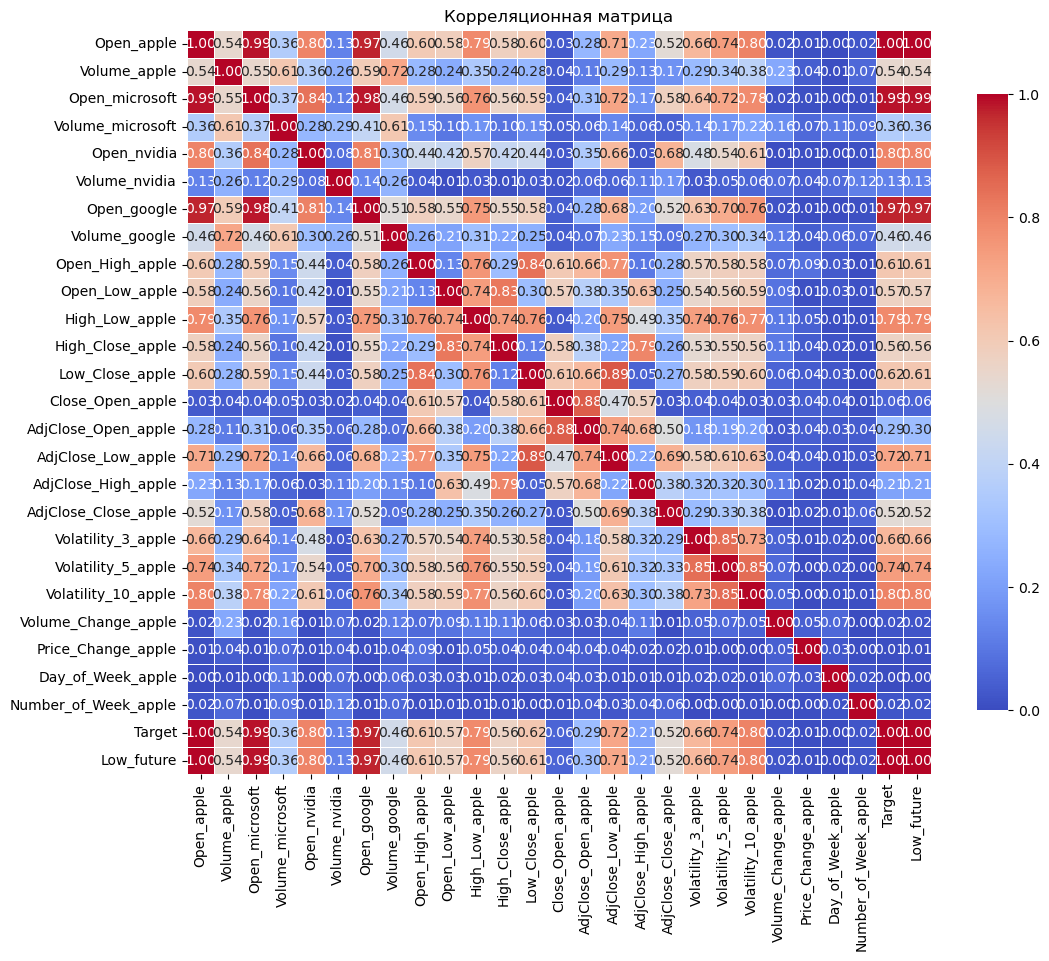

In [7]:
print('После удаления коллениарных признаков:')
lfa.plot_correlation_matrix(data)

In [8]:
lfa.data_review(data)

ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:


,Open_apple,Volume_apple,Open_microsoft,Volume_microsoft,Open_nvidia,Volume_nvidia,Open_google,Volume_google,Open_High_apple,Open_Low_apple,...,AdjClose_Close_apple,Volatility_3_apple,Volatility_5_apple,Volatility_10_apple,Volume_Change_apple,Price_Change_apple,Day_of_Week_apple,Number_of_Week_apple,Target,Low_future
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-21,7.574286,608154400,30.610001,73086700,0.433750,608632000,14.531532,253253712,-0.043928,0.173929,...,-1.155715,0.117882,0.087501,0.076642,-0.006532,-0.013168,3,3,7.385000,7.041429
2010-01-22,7.385000,881767600,30.000000,102004600,0.421250,1067916000,14.059800,273035583,-0.025714,0.343571,...,-1.098394,0.147395,0.113811,0.087888,0.449907,-0.024991,4,3,7.232500,7.149643
2010-01-25,7.232500,1065699600,29.240000,63373000,0.418250,643676000,13.613722,177458675,-0.078214,0.082857,...,-1.127944,0.171223,0.171169,0.124623,0.208595,-0.020650,0,4,7.355357,7.235000
2010-01-26,7.355357,1867110000,29.200001,66639900,0.416500,714636000,13.399027,174873019,-0.277143,0.120357,...,-1.143886,0.080859,0.177883,0.123319,0.752004,0.016987,1,4,7.387500,7.126071
2010-01-27,7.387500,1722568400,29.350000,63949500,0.405000,812504000,13.481219,159170382,-0.133214,0.261429,...,-1.154658,0.081805,0.122425,0.125264,-0.077415,0.004370,2,4,7.318929,7.096429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-12,222.500000,37498200,423.309998,17418800,116.839996,367100500,154.809998,21024100,-1.050003,2.679993,...,0.000000,1.841632,1.878722,4.108787,-0.158990,0.004696,3,37,223.580002,221.910004
2024-09-13,223.580002,36766600,425.829987,15874600,119.080002,238358300,156.362000,16733900,-0.459991,1.669998,...,0.000000,1.060060,1.763316,3.501867,-0.019510,0.004854,4,37,216.539993,213.919998
2024-09-16,216.539993,59357400,430.600006,13834700,116.790001,248772300,158.330002,14157600,-0.680008,2.619995,...,0.000000,3.791433,2.852020,3.174040,0.614438,-0.031488,0,38,215.750000,214.500000



ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3691 entries, 2010-01-21 to 2024-09-19
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open_apple            3691 non-null   float64
 1   Volume_apple          3691 non-null   int64  
 2   Open_microsoft        3691 non-null   float64
 3   Volume_microsoft      3691 non-null   int64  
 4   Open_nvidia           3691 non-null   float64
 5   Volume_nvidia         3691 non-null   int64  
 6   Open_google           3691 non-null   float64
 7   Volume_google         3691 non-null   int64  
 8   Open_High_apple       3691 non-null   float64
 9   Open_Low_apple        3691 non-null   float64
 10  High_Low_apple        3691 non-null   float64
 11  High_Close_apple      3691 non-null   float64
 12  Low_Close_apple       3691 non-null   float64
 13  Close_Open_apple      3691 non-null   float64
 14  AdjClose_Open_apple   369

,Open_apple,Volume_apple,Open_microsoft,Volume_microsoft,Open_nvidia,Volume_nvidia,Open_google,Volume_google,Open_High_apple,Open_Low_apple,...,AdjClose_Close_apple,Volatility_3_apple,Volatility_5_apple,Volatility_10_apple,Volume_Change_apple,Price_Change_apple,Day_of_Week_apple,Number_of_Week_apple,Target,Low_future
count,3691.000000,3.691000e+03,3691.000000,3.691000e+03,3691.000000,3.691000e+03,3691.000000,3.691000e+03,3691.000000,3691.000000,...,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.0,3691.000000,3691.000000
mean,66.738561,2.323841e+08,130.373828,3.639441e+07,11.701082,5.017156e+08,59.363222,5.336522e+07,-0.709142,0.675930,...,-2.135960,0.793619,1.014489,1.401034,0.050582,0.001086,2.025738,26.351395,66.798815,66.122295
std,61.680022,2.181682e+08,118.955057,2.089379e+07,22.654398,3.073424e+08,45.076564,4.836004e+07,1.103531,1.073109,...,0.704890,1.087689,1.260297,1.609375,0.362745,0.018452,1.398659,14.816577,61.730815,61.109282
min,6.870357,2.404830e+07,23.090000,7.425600e+06,0.218000,4.564400e+07,10.916831,1.584340e+05,-14.410004,0.000000,...,-3.808868,0.002974,0.019036,0.041124,-0.712266,-0.140904,0.000000,1.0,6.870357,6.794643
25%,20.403035,8.705320e+07,34.735001,2.284925e+07,0.439000,3.087320e+08,22.457948,2.432600e+07,-0.808750,0.097680,...,-2.542061,0.155070,0.221229,0.327683,-0.178797,-0.008088,1.000000,14.0,20.409464,20.222143
50%,36.252499,1.426898e+08,68.889999,3.052170e+07,3.266000,4.322600e+08,45.877499,3.403200e+07,-0.272499,0.260000,...,-2.255142,0.335599,0.449818,0.638673,-0.017509,0.001423,2.000000,26.0,36.275002,35.967499
75%,124.688751,3.102428e+08,224.964996,4.435695e+07,13.223750,6.063740e+08,88.888500,7.135044e+07,-0.102498,0.733750,...,-1.796854,0.992296,1.397211,1.994860,0.201534,0.010479,3.000000,39.0,124.753750,123.289997
max,236.479996,1.880998e+09,467.000000,3.193179e+08,139.800003,3.692928e+09,191.750000,5.952147e+08,0.000000,10.589996,...,0.000000,13.346225,11.037737,9.905964,5.090526,0.171182,4.000000,53.0,236.479996,233.089996


## Обучение
### Подготовка к обучению

In [9]:
# Сброс индекса или же удаление даты
data.reset_index(drop= True , inplace= True)

# Уменьшаем размерность данных, чтобы ускорить процессы обучения и предсказания
data = lfa.optimize_df(data)

Память до оптимизации: 771551 байт
Память после оптимизации: 406142 байт
Сокращение памяти: 47.36%


In [10]:
# разделим выборки на обучающую и тренировочную
X = data.drop(['Target', 'Low_future'], axis = 1)
y = data['Target']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False, random_state=RANDOM_STATE)

# Сохранение 'Low_future' для тестового набора
low_future = data['Low_future']
low_future_test = low_future.loc[xtest.index]

In [11]:
# Определение моделей
model_names = [
     'Ridge'
    , 'Lasso'
    , 'LinearRegression'
]

### Train
#### MAPE с масштабированием данных

In [12]:
best_models_mape_scale = {}
for model_name in model_names:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: lfa.objective_mape_scale(trial, model_name, xtrain, ytrain), n_trials=N_TRAILS)
    best_params = study.best_params if model_name != 'LinearRegression' else {}
    print(f"Best params for {model_name}: {best_params}")
    
    if model_name == 'Ridge':
        best_model = Ridge(random_state=RANDOM_STATE, **best_params)
    elif model_name == 'Lasso':
        best_model = Lasso(random_state=RANDOM_STATE, **best_params)
    else:
        best_model = LinearRegression()
    
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_model)
    ])
    
    best_pipeline.fit(xtrain, ytrain)
    best_models_mape_scale[model_name] = best_pipeline

Best params for Ridge: {'alpha': 0.2298654799833173}
Best params for Lasso: {'alpha': 0.024934205181999403}
Best params for LinearRegression: {}


In [13]:
# Оценка и выбор лучшей модели на обучающих данных
best_model_name = None
best_mape = float('inf')
for model_name, pipeline in best_models_mape_scale.items():
    preds = pipeline.predict(xtrain)
    mape = lfa.mean_absolute_percentage_error(ytrain, preds)
    print(f"MAPE for {model_name} on train data: {mape}")
    if mape < best_mape:
        best_mape = mape
        best_model_name = model_name

print(f"Best model on train data: {best_model_name} with MAPE: {best_mape}")

MAPE for Ridge on train data: 0.7304711391051287
MAPE for Lasso on train data: 0.7235413643179177
MAPE for LinearRegression on train data: 0.7269255456359363
Best model on train data: Lasso with MAPE: 0.7235413643179177


In [14]:
# Оценка лучшей модели на тестовых данных
best_pipeline = best_models_mape_scale[best_model_name]
test_preds_mape_scale = best_pipeline.predict(xtest)
test_mape = lfa.mean_absolute_percentage_error(ytest, test_preds_mape_scale)

print(f"MAPE для лучшей модели на тестовых данных: {test_mape}")

MAPE для лучшей модели на тестовых данных: 0.8039756455281504


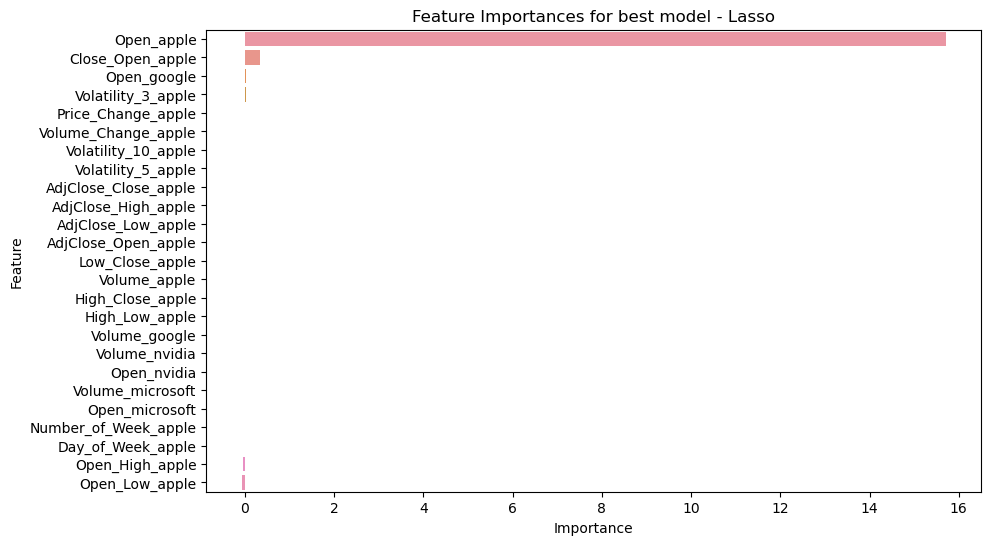

In [15]:
best_model = best_models_mape_scale[best_model_name]
feature_names = xtrain.columns
lfa.plot_feature_importances(best_model.named_steps['model'], feature_names, best_model_name)

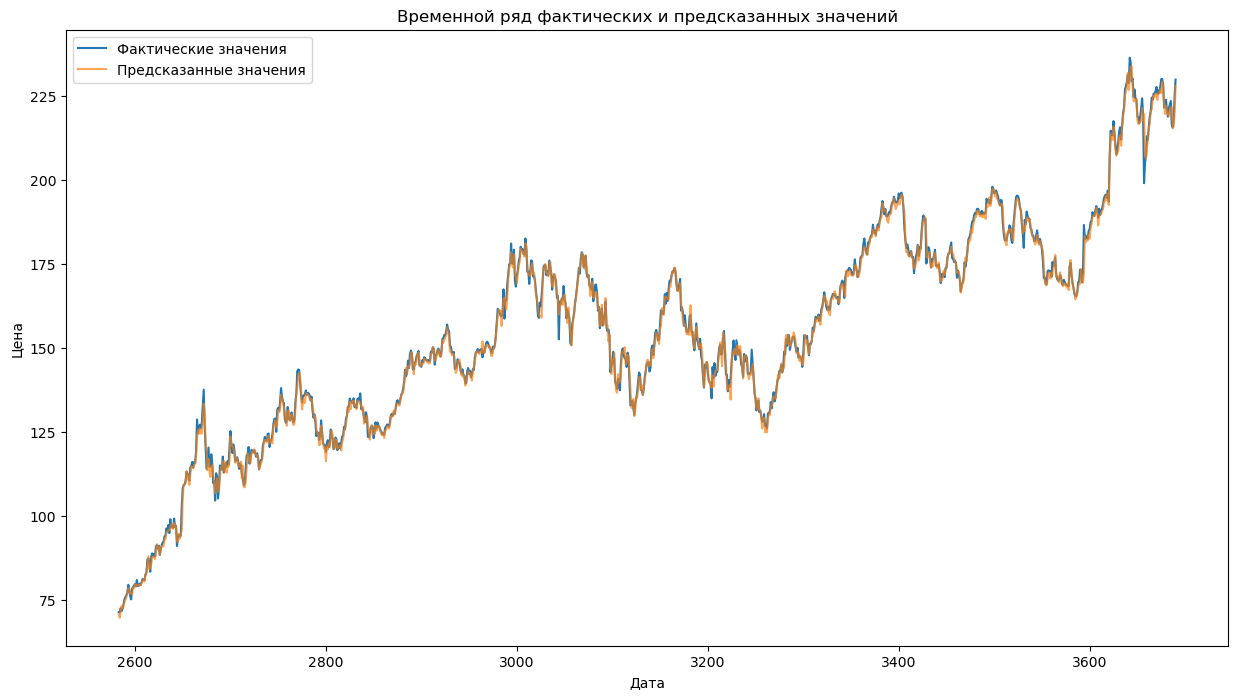

In [16]:
# Временной ряд фактических и предсказанных значений
plt.figure(figsize=(15, 8))
plt.plot(ytest.index, ytest, label='Фактические значения')
plt.plot(ytest.index, test_preds_mape_scale, label='Предсказанные значения', alpha=0.7)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Временной ряд фактических и предсказанных значений')
plt.legend()
plt.show()

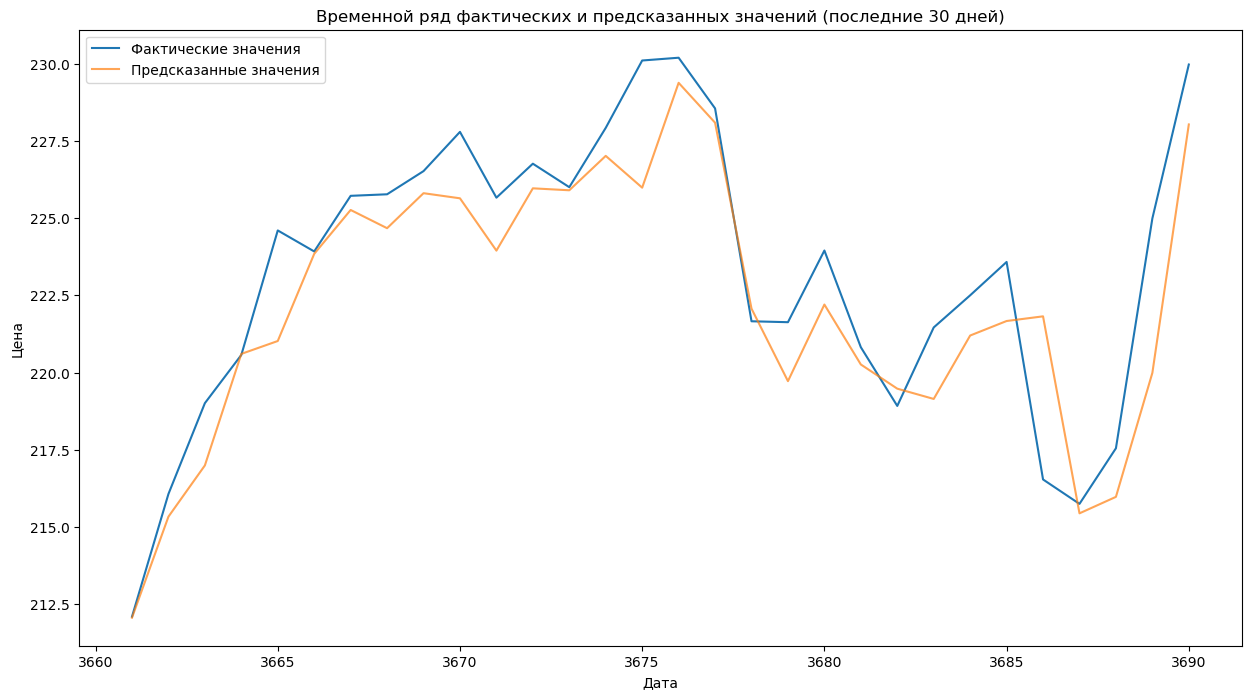

In [17]:
n = 30

# Ограничение данных последними n значениями
ytest_last_n = ytest[-n:]
test_preds_last_n = test_preds_mape_scale[-n:]

# Построение графика
plt.figure(figsize=(15, 8))
plt.plot(ytest_last_n.index, ytest_last_n, label='Фактические значения')
plt.plot(ytest_last_n.index, test_preds_last_n, label='Предсказанные значения', alpha=0.7)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title(f'Временной ряд фактических и предсказанных значений (последние {n} дней)')
plt.legend()
plt.show()

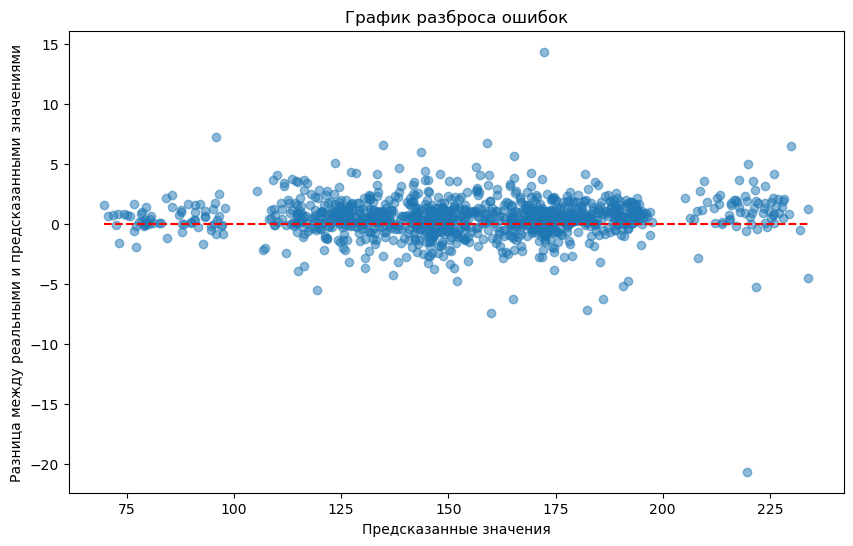

In [18]:
# Остаточные значения
residuals_mape_scale = ytest - test_preds_mape_scale

# График остаточных значений
plt.figure(figsize=(10, 6))
plt.scatter(test_preds_mape_scale, residuals_mape_scale, alpha=0.5)
plt.hlines(y=0, xmin=test_preds_mape_scale.min(), xmax=test_preds_mape_scale.max(), colors='r', linestyles='dashed')
plt.xlabel('Предсказанные значения')
plt.ylabel('Разница между реальными и предсказанными значениями')
plt.title('График разброса ошибок')
plt.show()

In [19]:
residuals_mape_scale.describe()

count    1108.000000
mean        0.497402
std         1.708488
min       -20.642527
25%        -0.190624
50%         0.562832
75%         1.257218
max        14.328014
Name: Target, dtype: float64

In [20]:
# Вычисление MAPE на тестовых данных
test_mape = lfa.mean_absolute_percentage_error(ytest, test_preds_mape_scale)
print(f"MAPE для лучшей модели на тестовых данных: {test_mape:.3f}%")

# Вычисление среднего изменения цены за день
average_cost = lfa.mean_absolute_percentage_error(ytest, low_future_test)
print(f"Среднее изменение цены за день: {average_cost:.3f}%")

print('')

# Вычисление средней цены акции на тестовых данных
average_price_test = np.mean(ytest)
print(f"Средняя цена акции на тестовых данных: {average_price_test:.3f}")

print('')

# Перевод MAPE в денежный эквивалент
average_absolute_error_dollars = (test_mape / 100) * average_price_test
print(f"Средняя абсолютная ошибка в долларах: ${average_absolute_error_dollars:.3f}")

# Перевод 'среднего абсолютного изменения цены за день' в денежный эквивалент
average_change_dollars = (average_cost / 100) * average_price_test
print(f"Средний разброс стоимости акции (от min до max) в долларах: ${average_change_dollars:.3f}")

# Отношение средней абсолютной ошибки к среднему разбросу стоимости акции за день
div_mape_avr_pr = test_mape/average_cost 
print(f"Отношение средней абсолютной ошибки к среднему разбросу стоимости акции за день: {div_mape_avr_pr:.3f}")


MAPE для лучшей модели на тестовых данных: 0.804%
Среднее изменение цены за день: 1.066%

Средняя цена акции на тестовых данных: 154.789

Средняя абсолютная ошибка в долларах: $1.244
Средний разброс стоимости акции (от min до max) в долларах: $1.650
Отношение средней абсолютной ошибки к среднему разбросу стоимости акции за день: 0.754
